## Resources
[Nature article: COVID-19 Mortality](https://www.nature.com/articles/s41598-020-68862-x)

## Contents
- [Imports](#Data-Dictionary)
- [Regression Modeling Age + Pop Density](#Regression-Modeling-Age-+-Pop-Density)  
- [Reg Model: 0-35, 35-59, 60-84, 85+](#Reg-Model:-0-35,-35-59,-60-84,-85+)
- [Reg Model: 0-44, 45-75, 75+](#-Reg-Model:-0-44,-45-75,-75+)
- [Reg Model: 0-64, 65+](#Reg-Model:-0-64,-65+)
- [Reg Model: Median Age](#Reg-Model:-Median-Age)
- [Correlations age](#Correlations-age)
- [Correlations the whole df](#Correlations-the-whole-df)
- [Regression Modeling Sex](#Regression-Modeling-Sex)

# Target Age Brackets 0-44, 45-75, 75+

# Imports

In [25]:
# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [17]:
# Import the Texas data and sae to a dataframe.
tx_df = pd.read_csv('../data/texas_combined_cleaned_WITH_Census_FA.csv')

In [18]:
# Display the first few rows of the dataframe.
tx_df.head(3)

,county_name,total_cases,total_fatalities,death_rate,race_pop,race_pop_hispanic_or_latino_of_any_race,race_pop_white_alone,race_pop_black_or_african_american_alone,race_pop_american_indian_and_alaska_native_alone,race_pop_asian_alone,...,inc_hhlds_100_000_to_149_999,inc_hhlds_150_000_to_199_999,inc_hhlds_200_000_or_more,inc_med_hhld_inc_dol,inc_mean_hhld_inc_dol,inc_per_capita_inc_dol,inc_med_earn_workers_dol,inc_med_earn_male_full_yr_workers_dol,inc_med_earn_female_full_yr_workers_dol,pop_density
0,anderson,2922.0,39,0.013347,57863,10142,34312,12127,158,319,...,1432,422,240,43355,55852,16868,26621,36865,26890,54.452632
1,andrews,567.0,10,0.017637,17818,9979,7215,321,0,63,...,1214,398,352,74233,94962,31190,40478,72970,35194,11.872960
2,angelina,2277.0,90,0.039526,87607,19174,53216,12834,107,987,...,3257,985,639,47714,61152,22322,27411,41488,32622,109.813207


In [19]:
# Display information about the dataframe.
tx_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 54 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   county_name                                                254 non-null    object 
 1   total_cases                                                254 non-null    float64
 2   total_fatalities                                           254 non-null    int64  
 3   death_rate                                                 254 non-null    float64
 4   race_pop                                                   254 non-null    int64  
 5   race_pop_hispanic_or_latino_of_any_race                    254 non-null    int64  
 6   race_pop_white_alone                                       254 non-null    int64  
 7   race_pop_black_or_african_american_alone                   254 non-null    int64  
 8   race_pop_a

In [20]:
# Set the county name to the index.
tx_df = tx_df.set_index('county_name')

In [28]:
# Create a column for the numer of deaths per 100 cases.
tx_df['deaths_per_100_cases'] = tx_df['death_rate'] * 100

# Regression Modeling Age + Pop Density

In [29]:
# Create a subset of age demographic columns for modeling.
# Extract columns for age-based model.
age_mod_cols = [
    'total_cases', 'total_fatalities', 'death_rate', 'deaths_per_100_cases', 'sex_age_pop', 'sex_age_pop_male', 'sex_age_pop_female',
    'sex_age_pop_under_5', 'sex_age_pop_5_to_9', 'sex_age_pop_10_to_14', 'sex_age_pop_15_to_19',
    'sex_age_pop_20_to_24', 'sex_age_pop_25_to_34', 'sex_age_pop_35_to_44', 'sex_age_pop_45_to_54',
    'sex_age_pop_55_to_59', 'sex_age_pop_60_to_64', 'sex_age_pop_65_to_74', 'sex_age_pop_75_to_84',
    'sex_age_pop_85_and_over', 'pop_density', 'sex_age_median_age_in_years'
]

In [30]:
# Create a dataframe for age groups
tx_age = tx_df[age_mod_cols]

## Reg Model: 0-35, 35-59, 60-84, 85+

In [31]:
tx_age['sex_age_pop_0_to_35'] = tx_age['sex_age_pop_under_5'] + tx_age['sex_age_pop_5_to_9'] + tx_age['sex_age_pop_10_to_14'] + tx_age['sex_age_pop_15_to_19'] + tx_age['sex_age_pop_20_to_24'] + tx_age['sex_age_pop_25_to_34']

In [32]:
tx_age['sex_age_pop_35_to_59'] = tx_age['sex_age_pop_35_to_44'] + tx_age['sex_age_pop_45_to_54'] + tx_age['sex_age_pop_55_to_59']

In [33]:
tx_age['sex_age_pop_60_to_84'] = tx_age['sex_age_pop_60_to_64'] + tx_age['sex_age_pop_65_to_74'] + tx_age['sex_age_pop_75_to_84']

In [34]:
# Define a function to create new columns with percentages.
def to_percentage(dataframe):
    for column in dataframe.columns:
        if column.startswith('sex_age_pop_'):
            dataframe['percent_' + column] = dataframe[column] / dataframe['sex_age_pop']
    return

In [35]:
# Apply the function to the numbers dataframe
to_percentage(tx_age)

In [36]:
list(tx_age.columns)

['total_cases',
 'total_fatalities',
 'death_rate',
 'deaths_per_100_cases',
 'sex_age_pop',
 'sex_age_pop_male',
 'sex_age_pop_female',
 'sex_age_pop_under_5',
 'sex_age_pop_5_to_9',
 'sex_age_pop_10_to_14',
 'sex_age_pop_15_to_19',
 'sex_age_pop_20_to_24',
 'sex_age_pop_25_to_34',
 'sex_age_pop_35_to_44',
 'sex_age_pop_45_to_54',
 'sex_age_pop_55_to_59',
 'sex_age_pop_60_to_64',
 'sex_age_pop_65_to_74',
 'sex_age_pop_75_to_84',
 'sex_age_pop_85_and_over',
 'pop_density',
 'sex_age_median_age_in_years',
 'sex_age_pop_0_to_35',
 'sex_age_pop_35_to_59',
 'sex_age_pop_60_to_84',
 'percent_sex_age_pop_male',
 'percent_sex_age_pop_female',
 'percent_sex_age_pop_under_5',
 'percent_sex_age_pop_5_to_9',
 'percent_sex_age_pop_10_to_14',
 'percent_sex_age_pop_15_to_19',
 'percent_sex_age_pop_20_to_24',
 'percent_sex_age_pop_25_to_34',
 'percent_sex_age_pop_35_to_44',
 'percent_sex_age_pop_45_to_54',
 'percent_sex_age_pop_55_to_59',
 'percent_sex_age_pop_60_to_64',
 'percent_sex_age_pop_65_to_7

In [45]:
X = tx_age[[
    'percent_sex_age_pop_0_to_35',
    'percent_sex_age_pop_35_to_59',
    'percent_sex_age_pop_60_to_84',
    'percent_sex_age_pop_85_and_over',
    'pop_density'
]]

y = tx_age['deaths_per_100_cases']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [46]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [47]:
lr = LinearRegression()
lr.fit(X_train_ss, y_train)

LinearRegression()

In [48]:
X_train.shape, y_test.shape

((190, 5), (64,))

In [49]:
cross_val_score(lr, X_test_ss, y_test, cv=5).mean()

-0.49662877494419694

## Reg Model: 0-44, 45-75, 75+

In [63]:
tx_age['sex_age_pop_0_to_44'] = tx_age['sex_age_pop_under_5'] + tx_age['sex_age_pop_5_to_9'] + tx_age['sex_age_pop_10_to_14'] + tx_age['sex_age_pop_15_to_19'] + tx_age['sex_age_pop_20_to_24'] + tx_age['sex_age_pop_25_to_34'] + tx_age['sex_age_pop_35_to_44']

In [64]:
tx_age['sex_age_pop_45_to_74'] = tx_age['sex_age_pop_45_to_54'] + tx_age['sex_age_pop_55_to_59'] + tx_age['sex_age_pop_60_to_64'] + tx_age['sex_age_pop_65_to_74']

In [65]:
tx_age['sex_age_pop_75_and_over'] = tx_age['sex_age_pop_75_to_84'] + tx_age['sex_age_pop_85_and_over']

In [28]:
# Define a function to create new columns with percentages.
def to_percentage(dataframe):
    
    for column in dataframe.columns:
        if column.startswith('sex_age_pop_'):
            dataframe['percent_' + column] = dataframe[column] / dataframe['sex_age_pop']
    
    return

In [29]:
# Apply the function to the numbers dataframe
to_percentage(tx_age)

In [30]:
list(tx_age.columns)

['total_cases',
 'total_fatalities',
 'death_rate',
 'sex_age_pop',
 'sex_age_pop_male',
 'sex_age_pop_female',
 'sex_age_pop_under_5',
 'sex_age_pop_5_to_9',
 'sex_age_pop_10_to_14',
 'sex_age_pop_15_to_19',
 'sex_age_pop_20_to_24',
 'sex_age_pop_25_to_34',
 'sex_age_pop_35_to_44',
 'sex_age_pop_45_to_54',
 'sex_age_pop_55_to_59',
 'sex_age_pop_60_to_64',
 'sex_age_pop_65_to_74',
 'sex_age_pop_75_to_84',
 'sex_age_pop_85_and_over',
 'pop_density',
 'sex_age_median_age_in_years',
 'sex_age_pop_0_to_44',
 'sex_age_pop_45_to_74',
 'sex_age_pop_75_and_over',
 'percent_sex_age_pop_male',
 'percent_sex_age_pop_female',
 'percent_sex_age_pop_under_5',
 'percent_sex_age_pop_5_to_9',
 'percent_sex_age_pop_10_to_14',
 'percent_sex_age_pop_15_to_19',
 'percent_sex_age_pop_20_to_24',
 'percent_sex_age_pop_25_to_34',
 'percent_sex_age_pop_35_to_44',
 'percent_sex_age_pop_45_to_54',
 'percent_sex_age_pop_55_to_59',
 'percent_sex_age_pop_60_to_64',
 'percent_sex_age_pop_65_to_74',
 'percent_sex_age_

In [31]:
X = tx_age[[
    'percent_sex_age_pop_0_to_44',
    'percent_sex_age_pop_45_to_74',
    'percent_sex_age_pop_75_and_over',
    'pop_density'
]]

y = tx_age['death_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [32]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [33]:
lr = LinearRegression()
lr.fit(X_train_ss, y_train)

LinearRegression()

In [34]:
X_train.shape, y_test.shape

((190, 4), (64,))

In [35]:
cross_val_score(lr, X_test_ss, y_test, cv=5).mean()

-0.19903218313245744

## Reg Model: 0-64, 65+

In [66]:
tx_age['sex_age_pop_0_to_64'] = tx_age['sex_age_pop_under_5'] + tx_age['sex_age_pop_5_to_9'] + tx_age['sex_age_pop_10_to_14']\
                                + tx_age['sex_age_pop_15_to_19'] + tx_age['sex_age_pop_20_to_24'] + tx_age['sex_age_pop_25_to_34'] \
                                + tx_age['sex_age_pop_35_to_44'] + tx_age['sex_age_pop_45_to_54'] + tx_age['sex_age_pop_55_to_59'] \
                                + tx_age['sex_age_pop_60_to_64']

In [67]:
tx_age['sex_age_pop_65_and_over'] = tx_age['sex_age_pop_65_to_74'] + tx_age['sex_age_pop_75_to_84'] + tx_age['sex_age_pop_85_and_over']

In [73]:
# Define a function to create new columns with percentages.
def to_percentage(dataframe):
    for column in dataframe.columns:
        if column.startswith('sex_age_pop_'):
            dataframe['percent_' + column] = dataframe[column] / dataframe['sex_age_pop']
    return

In [74]:
# Apply the function to the numbers dataframe
to_percentage(tx_age)

In [42]:
list(tx_age.columns)

['total_cases',
 'total_fatalities',
 'death_rate',
 'sex_age_pop',
 'sex_age_pop_male',
 'sex_age_pop_female',
 'sex_age_pop_under_5',
 'sex_age_pop_5_to_9',
 'sex_age_pop_10_to_14',
 'sex_age_pop_15_to_19',
 'sex_age_pop_20_to_24',
 'sex_age_pop_25_to_34',
 'sex_age_pop_35_to_44',
 'sex_age_pop_45_to_54',
 'sex_age_pop_55_to_59',
 'sex_age_pop_60_to_64',
 'sex_age_pop_65_to_74',
 'sex_age_pop_75_to_84',
 'sex_age_pop_85_and_over',
 'pop_density',
 'sex_age_median_age_in_years',
 'sex_age_pop_0_to_64',
 'sex_age_pop_65_and_over',
 'percent_sex_age_pop_male',
 'percent_sex_age_pop_female',
 'percent_sex_age_pop_under_5',
 'percent_sex_age_pop_5_to_9',
 'percent_sex_age_pop_10_to_14',
 'percent_sex_age_pop_15_to_19',
 'percent_sex_age_pop_20_to_24',
 'percent_sex_age_pop_25_to_34',
 'percent_sex_age_pop_35_to_44',
 'percent_sex_age_pop_45_to_54',
 'percent_sex_age_pop_55_to_59',
 'percent_sex_age_pop_60_to_64',
 'percent_sex_age_pop_65_to_74',
 'percent_sex_age_pop_75_to_84',
 'percent_

In [43]:
X = tx_age[[
    'percent_sex_age_pop_0_to_64',
    'percent_sex_age_pop_65_and_over',
    'pop_density'
]]

y = tx_age['death_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [44]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [45]:
lr = LinearRegression()
lr.fit(X_train_ss, y_train)

LinearRegression()

In [46]:
X_train.shape, y_test.shape

((190, 3), (64,))

In [47]:
cross_val_score(lr, X_test_ss, y_test, cv=5).mean()

-0.39092620798816424

## Reg Model: Median Age

In [50]:
X = tx_age[[
    'sex_age_median_age_in_years',
    'pop_density'
]]

y = tx_age['death_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [51]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [52]:
lr = LinearRegression()
lr.fit(X_train_ss, y_train)

LinearRegression()

In [53]:
X_train.shape, y_test.shape

((190, 2), (64,))

In [54]:
cross_val_score(lr, X_test_ss, y_test, cv=5).mean()

-0.21220392782817105

# Correlations age

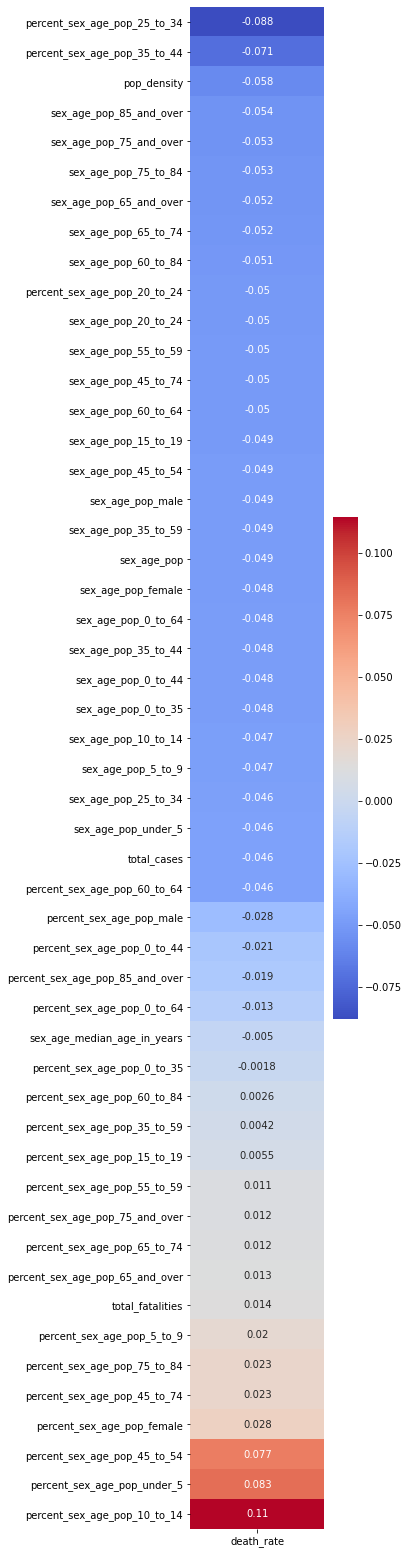

In [77]:
# Visualize the correlation between the variables.
# Save a correlation table to a variable.
corr = tx_age.corr()

# Display a correlation chart just for Sale Price.
plt.figure(figsize=(3, 28))
sns.heatmap(corr[['death_rate']].sort_values(by='death_rate').iloc[:-1], annot=True, cmap = 'coolwarm');

# Correlations the whole df

In [79]:
list(tx_df.columns)

['total_cases',
 'total_fatalities',
 'death_rate',
 'race_pop',
 'race_pop_hispanic_or_latino_of_any_race',
 'race_pop_white_alone',
 'race_pop_black_or_african_american_alone',
 'race_pop_american_indian_and_alaska_native_alone',
 'race_pop_asian_alone',
 'race_pop_native_hawaiian_and_other_pacific_islander_alone',
 'race_pop_some_other_race_alone',
 'race_pop_two_or_more_races',
 'sex_age_pop',
 'sex_age_pop_male',
 'sex_age_pop_female',
 'sex_age_pop_under_5',
 'sex_age_pop_5_to_9',
 'sex_age_pop_10_to_14',
 'sex_age_pop_15_to_19',
 'sex_age_pop_20_to_24',
 'sex_age_pop_25_to_34',
 'sex_age_pop_35_to_44',
 'sex_age_pop_45_to_54',
 'sex_age_pop_55_to_59',
 'sex_age_pop_60_to_64',
 'sex_age_pop_65_to_74',
 'sex_age_pop_75_to_84',
 'sex_age_pop_85_and_over',
 'sex_age_median_age_in_years',
 'sq_mi',
 'health_ins_noninst_pop',
 'health_ins_noninst_pop_cov_yes',
 'health_ins_noninst_pop_private',
 'health_ins_noninst_pop_public',
 'health_ins_noninst_pop_cov_no',
 'inc_hhlds',
 'inc_hhl

In [80]:
# Define a function to create new columns with percentages.
def to_percentage(dataframe):
    
    for column in dataframe.columns:
        if column.startswith('race_pop_'):
            dataframe['percent_' + column] = dataframe[column] / dataframe['race_pop']
        
        elif column.startswith('sex_age_pop_'):
            dataframe['percent_' + column] = dataframe[column] / dataframe['sex_age_pop']
            
        elif column.startswith('health_ins_noninst_pop_cov'):
            dataframe['percent_' + column] = dataframe[column] / dataframe['health_ins_noninst_pop']
            
        elif column.startswith('inc_hhlds_'):
            dataframe['percent_' + column] = dataframe[column] / dataframe['inc_hhlds']
    
    return

In [81]:
to_percentage(tx_df)

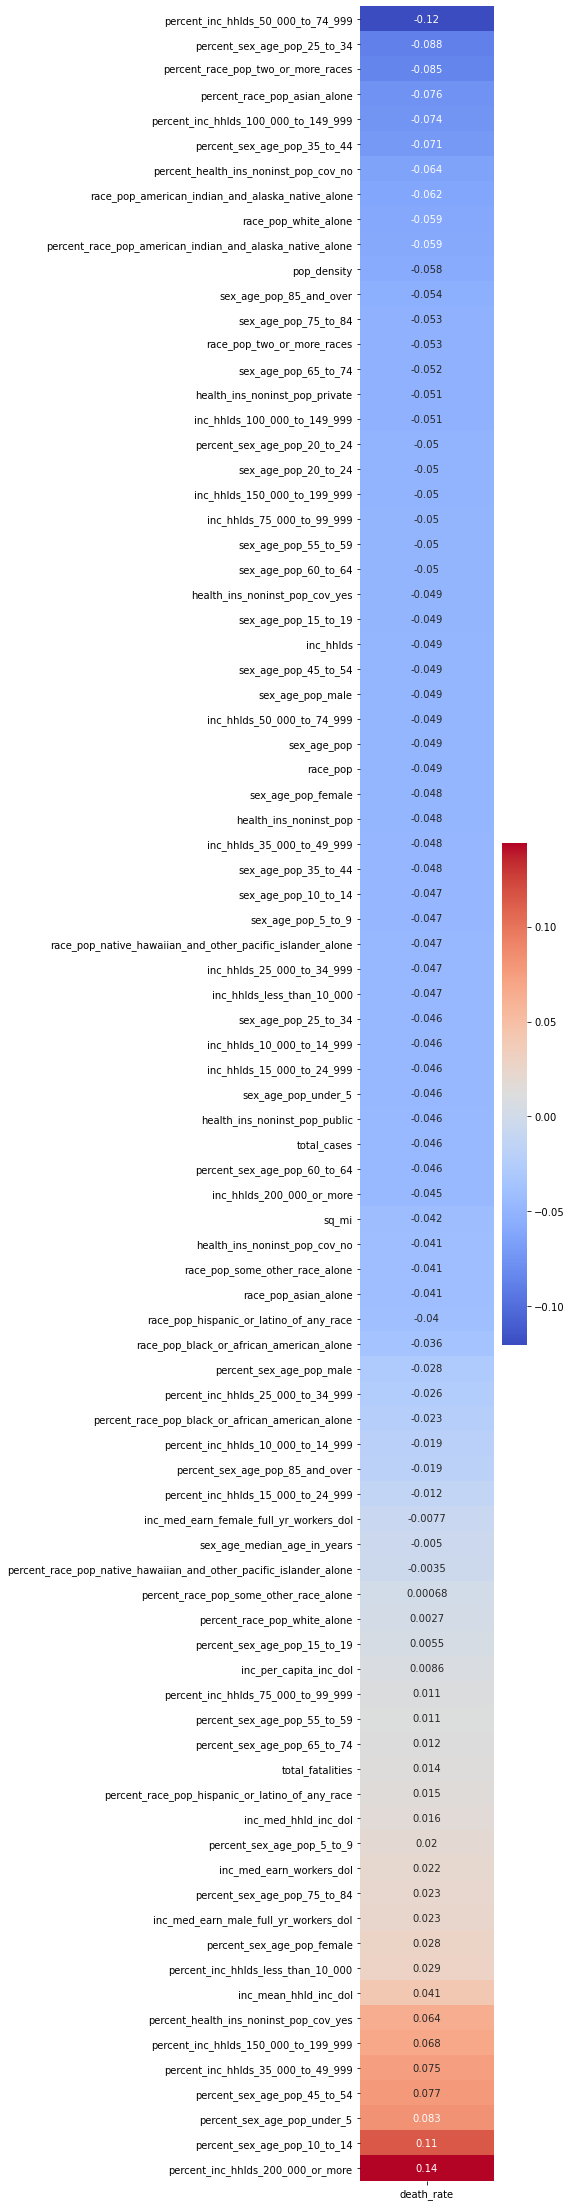

In [82]:
# Visualize the correlation between the variables.
# Save a correlation table to a variable.
corr = tx_df.corr()

# Display a correlation chart just for Sale Price.
plt.figure(figsize=(3, 40))
sns.heatmap(corr[['death_rate']].sort_values(by='death_rate').iloc[:-1], annot=True, cmap = 'coolwarm');

# Regression Modeling Sex

In [83]:
list(tx_df.columns)

['total_cases',
 'total_fatalities',
 'death_rate',
 'race_pop',
 'race_pop_hispanic_or_latino_of_any_race',
 'race_pop_white_alone',
 'race_pop_black_or_african_american_alone',
 'race_pop_american_indian_and_alaska_native_alone',
 'race_pop_asian_alone',
 'race_pop_native_hawaiian_and_other_pacific_islander_alone',
 'race_pop_some_other_race_alone',
 'race_pop_two_or_more_races',
 'sex_age_pop',
 'sex_age_pop_male',
 'sex_age_pop_female',
 'sex_age_pop_under_5',
 'sex_age_pop_5_to_9',
 'sex_age_pop_10_to_14',
 'sex_age_pop_15_to_19',
 'sex_age_pop_20_to_24',
 'sex_age_pop_25_to_34',
 'sex_age_pop_35_to_44',
 'sex_age_pop_45_to_54',
 'sex_age_pop_55_to_59',
 'sex_age_pop_60_to_64',
 'sex_age_pop_65_to_74',
 'sex_age_pop_75_to_84',
 'sex_age_pop_85_and_over',
 'sex_age_median_age_in_years',
 'sq_mi',
 'health_ins_noninst_pop',
 'health_ins_noninst_pop_cov_yes',
 'health_ins_noninst_pop_private',
 'health_ins_noninst_pop_public',
 'health_ins_noninst_pop_cov_no',
 'inc_hhlds',
 'inc_hhl

In [84]:
# Create a subset of sex demographic columns for modeling.
# Extract columns for sex-based model.
sex_mod_cols = ['sex_age_pop', 'sex_age_pop_male', 'sex_age_pop_female', 'pop_density', 'death_rate']

In [85]:
# Create a dataframe for age groups
tx_sex = tx_df[sex_mod_cols]

In [86]:
tx_sex

,sex_age_pop,sex_age_pop_male,sex_age_pop_female,pop_density,death_rate
county_name,,,,,
anderson,57863,35412,22451,54.452632,0.013347
andrews,17818,9102,8716,11.872960,0.017637
angelina,87607,42659,44948,109.813207,0.039526
aransas,24763,12026,12737,98.246769,0.052941
archer,8789,4326,4463,9.729998,0.007519
...,...,...,...,...,...
wood,43815,21807,22008,67.904439,0.057971
yoakum,8571,4438,4133,10.717568,0.017301
young,18114,8930,9184,19.807588,0.012072


In [87]:
# Define a function to create new columns with percentages.
def to_percentage(dataframe):
    
    for column in dataframe.columns:
        if column.startswith('sex_age_pop_'):
            dataframe['percent_' + column] = dataframe[column] / dataframe['sex_age_pop']
            
    return

In [88]:
to_percentage(tx_sex)

In [89]:
tx_sex

,sex_age_pop,sex_age_pop_male,sex_age_pop_female,pop_density,death_rate,percent_sex_age_pop_male,percent_sex_age_pop_female
county_name,,,,,,,
anderson,57863,35412,22451,54.452632,0.013347,0.611997,0.388003
andrews,17818,9102,8716,11.872960,0.017637,0.510832,0.489168
angelina,87607,42659,44948,109.813207,0.039526,0.486936,0.513064
aransas,24763,12026,12737,98.246769,0.052941,0.485644,0.514356
archer,8789,4326,4463,9.729998,0.007519,0.492206,0.507794
...,...,...,...,...,...,...,...
wood,43815,21807,22008,67.904439,0.057971,0.497706,0.502294
yoakum,8571,4438,4133,10.717568,0.017301,0.517793,0.482207
young,18114,8930,9184,19.807588,0.012072,0.492989,0.507011


In [90]:
X = tx_sex[[
    'percent_sex_age_pop_male',
    'percent_sex_age_pop_female',
    'pop_density'
]]

y = tx_sex['death_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [91]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [92]:
lr = LinearRegression()
lr.fit(X_train_ss, y_train)

LinearRegression()

In [93]:
X_train.shape, y_test.shape

((190, 3), (64,))

In [94]:
cross_val_score(lr, X_test_ss, y_test, cv=5).mean()

-0.2768627602711874